# Employee Attrition Prediction Model

*Group Members: Michael Li, Marco Ma, Jack Zilles, Elliot Hong, Ronan Loberg*

The model uses Employee Attrition dataset from Kaggle's and compares the effectiveness between using Logistic Regression, Neural Network, and Random Forest. We start by analyzing the dataset, keeping the significant ones and removing the uncorrelated ones to optimize performance from our models. Then we proceed to parsing, splitting, and normalizing before training our models. Below are explanations to our work and our code.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


## Data Parsing

We start with all the data given from the dataset. The raw dataset has 1470 rows and 35 features including Attrition, which is our desired output feature. In terms of data types, there are 26 numerical features and 9 categorical features, ranging from 2 to 6 categories each.

One challenge for our particular dataset is the significant imbalance of the dataset. There are ~83% 'no' responses to attrition, which means we need to employ different techniques to resolve this issue. Namely, we used SMOTE to oversample the minority class, and used ROC AUC to evaluate our model's performance, which is a better metric than accuracy when the dataset is skewed.

### 1. Load, inspect, and modify the data

We can see that all of the data is in numerical form or boolean object which we will one hot encode later.

In [3]:
data = pd.read_csv("EmployeeAttritionAllData.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Because we are working with employee attrition rate, there is a significant imbalance in our data. Roughly 83% of the data answered 'no' in attrition. This is our main challenge in developing the model. We need to use what we learned to account for the biased dataset. As an overview, we used SMOTE to oversample the minority class, and used ROC AUC as our main evaluation of the models robustness.

#### Data Cleaning

We want to check if any row of data is missing value or have repeating values for whole column

In [3]:
# Check for missing data
missing_values = data.isnull().sum()

# Check for constant data
no_unique_values = data.nunique()

missing_values, no_unique_values

(Age                         0
 Attrition                   0
 BusinessTravel              0
 DailyRate                   0
 Department                  0
 DistanceFromHome            0
 Education                   0
 EducationField              0
 EmployeeCount               0
 EmployeeNumber              0
 EnvironmentSatisfaction     0
 Gender                      0
 HourlyRate                  0
 JobInvolvement              0
 JobLevel                    0
 JobRole                     0
 JobSatisfaction             0
 MaritalStatus               0
 MonthlyIncome               0
 MonthlyRate                 0
 NumCompaniesWorked          0
 Over18                      0
 OverTime                    0
 PercentSalaryHike           0
 PerformanceRating           0
 RelationshipSatisfaction    0
 StandardHours               0
 StockOptionLevel            0
 TotalWorkingYears           0
 TrainingTimesLastYear       0
 WorkLifeBalance             0
 YearsAtCompany              0
 YearsIn

While there is no missing values found, 3 columns ('EmployeeCount', 'Over18', 'StandardHours') were found to have constant values for all 1470 rows. Also, 'EmployeeNumber' is a unique identifier for all 1470 rows. These 4 columns should be dropped because they will not help our model.

In [4]:
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
data = data.drop(columns=columns_to_drop)

X = data.drop(columns=['Attrition'])
y = data['Attrition']

categorical_cols = X.select_dtypes(include=[object]).columns.tolist()

# OHE
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

y = y.map({'Yes': 1, 'No': 0})

Now we also need to determine the redundant data. For example, *Monthly Income* can be correlated with *Job Level*, and hence one of them should be removed to reduce redundancy in the data and improve performance. A simple analysis of the coefficient of correlation reveals that a few more columns should be dropped. Namely:
* *Monthly Income* is strongly correlated with *Job Level* with a correlation coefficient of 0.95.
* *TotalWorkingYears* is strongly correlated with *Job Level* and *Monthly Income*, which is expected as more experienced employees are likely at a higher job level and earn more.
* *YearsWithCurrManager*, *YearsAtCompany*, and *YearsInCurrentRole* are also strong correlated with each other.

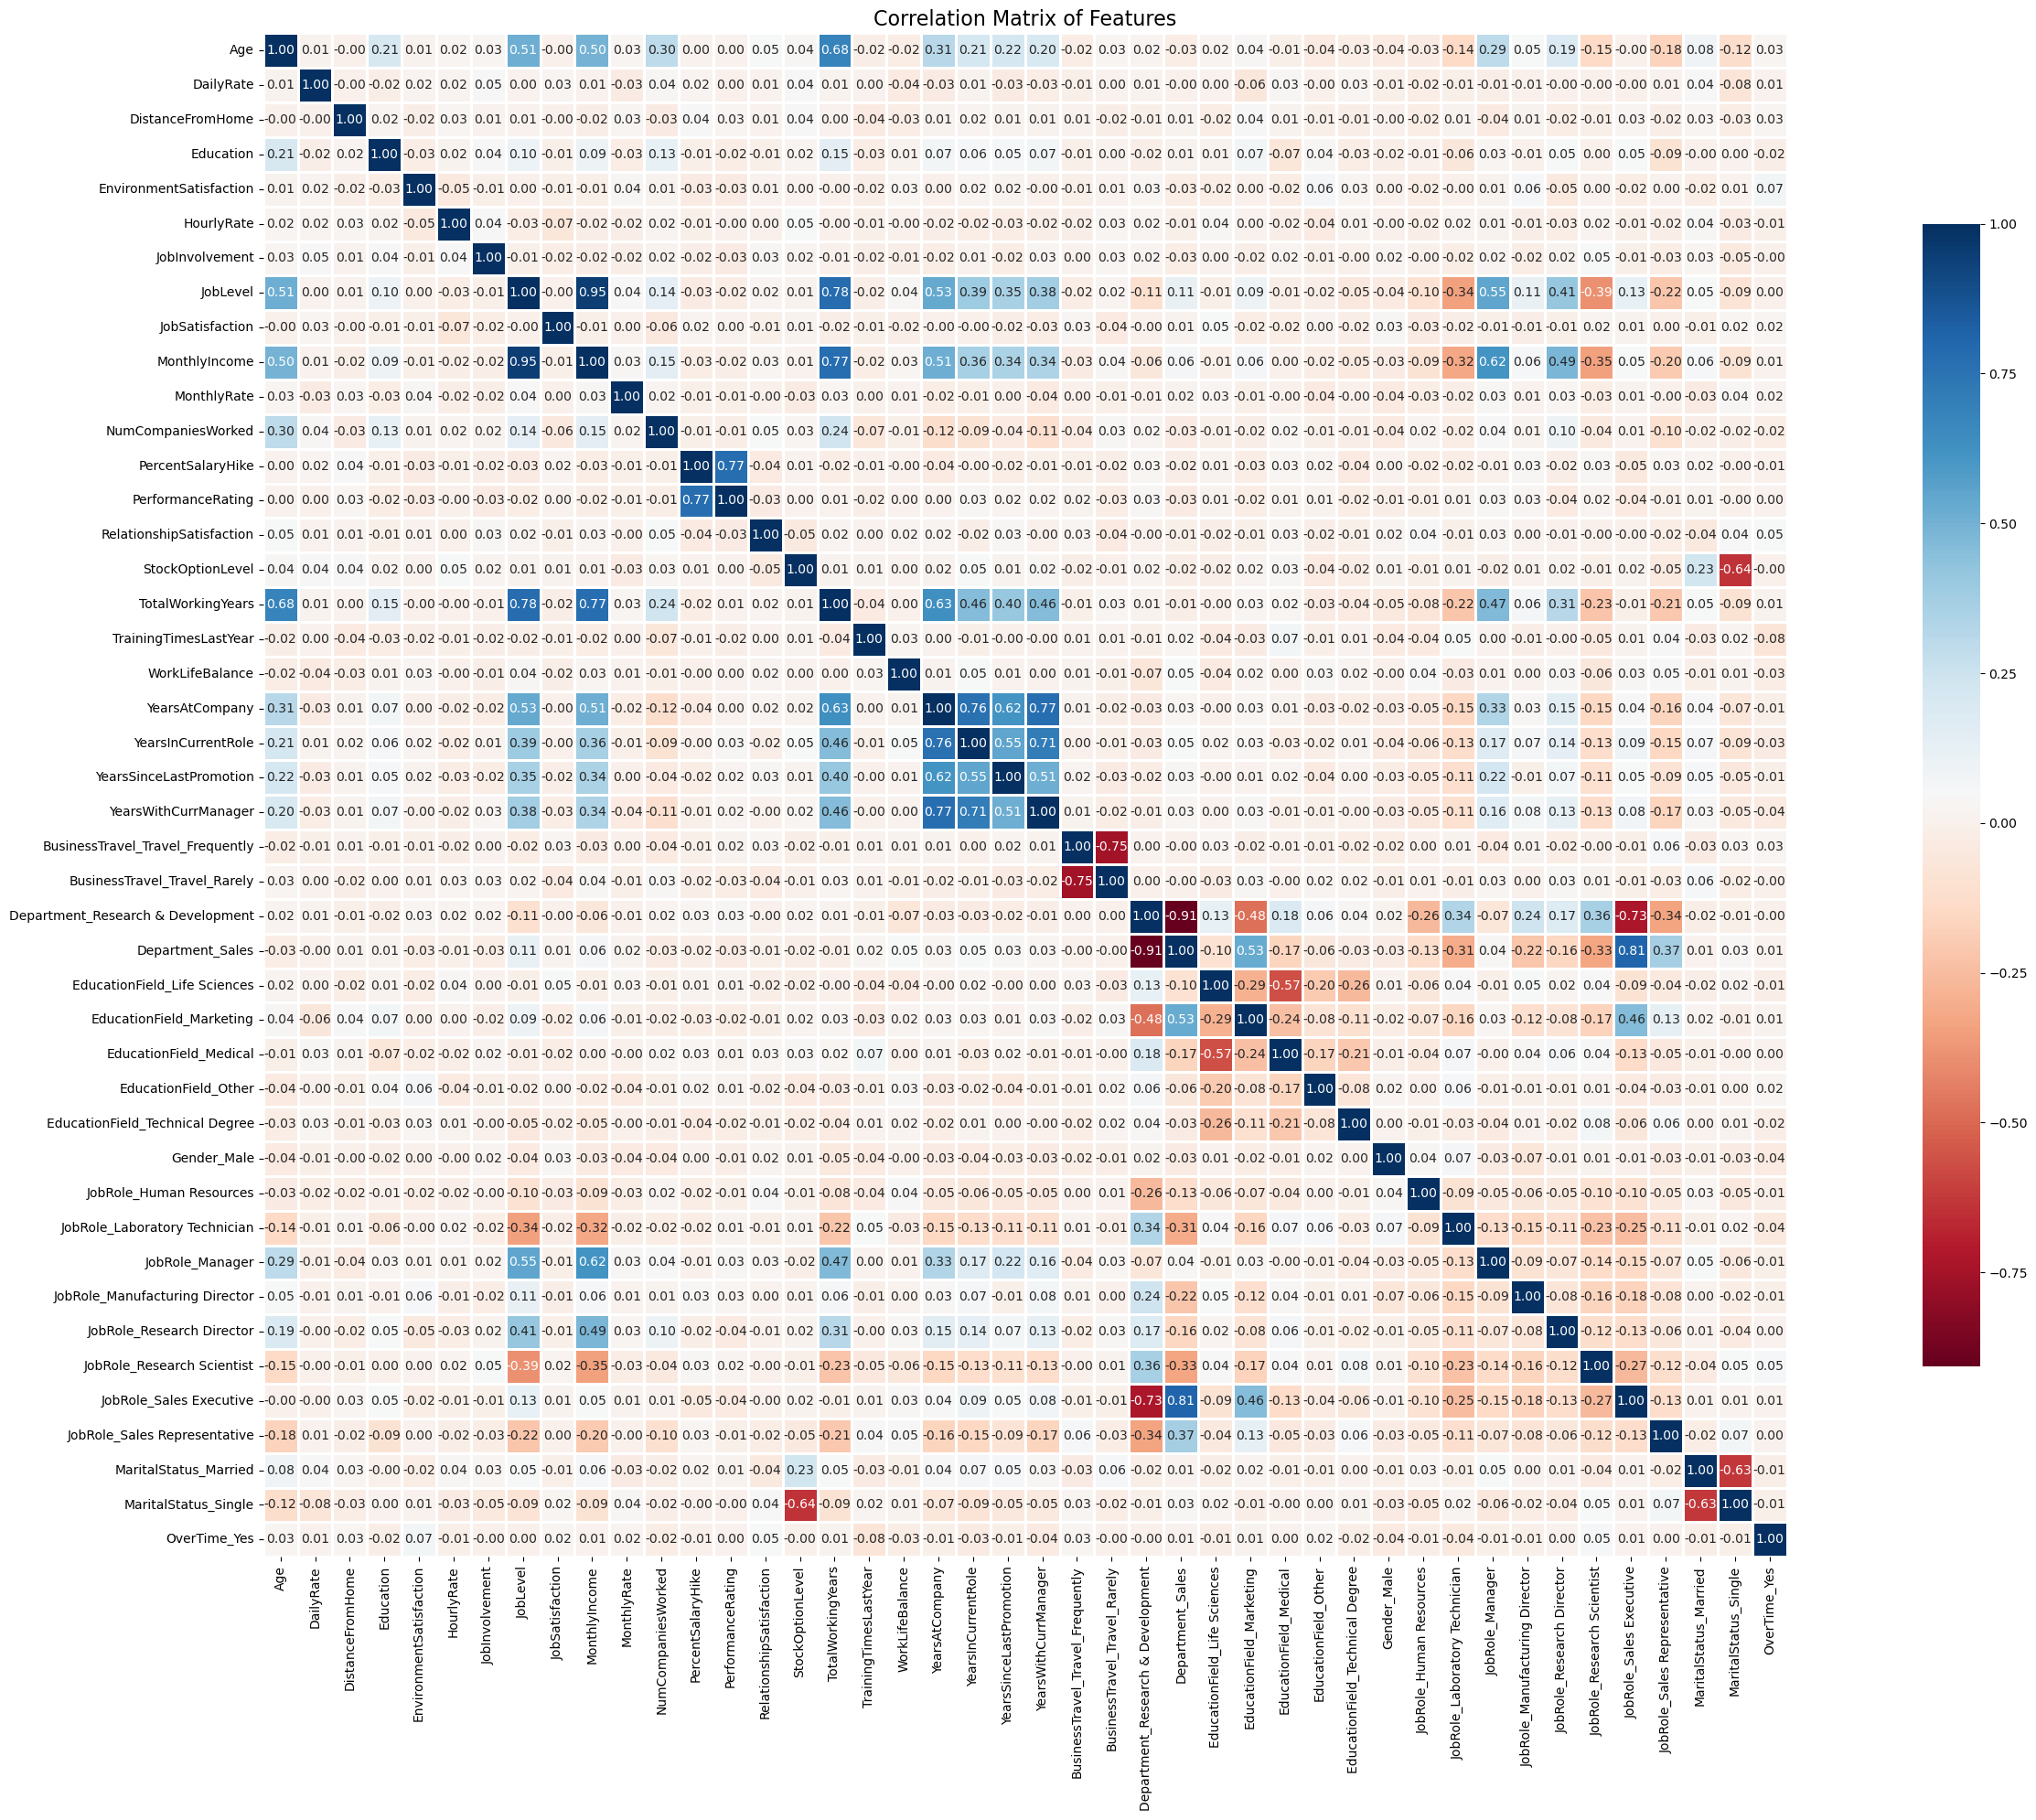

In [5]:
# Correlation Matrix
correlation_matrix = X.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu', cbar=True, square=True, 
            cbar_kws={"shrink": .75}, linewidths=1)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.tight_layout()
plt.show()

*MonthlyIncome*, *TotalWorkingYears*, *YearsInCurrentRole* and *YearsWithCurrManager* are removed using a cutoff of 0.7 correlation coefficient.

In [6]:
columns_to_drop = ['MonthlyIncome','TotalWorkingYears','YearsInCurrentRole','YearsWithCurrManager']
data = data.drop(columns=columns_to_drop)

### 2. OHE & Extract test data

One hot encode categorical data into binary numerical data and then split testing and training data. Making sure to train/test split before normalization so there is no data leakage problems.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Normalize the training data

Next we will standardize the data. The algorithm is technically the same with normalized and un-normalized data. However it can have beneficial effects on the convergence of the optimization solver later. Also we normalize using x-train and then use the same parameter to normalize x-test to ensure no data leakage. This is an important point as we are normalizing after we split the data into training, validation, and testing sets.


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])

## Simple logistic regression

**Simple logistic regression**

1. Train simple logistic regression
2. Evaluate the models with cross-validation

**Regularization**

3. LASSO regularized logistic regression
4. Choose the best model
5. Evaluate the final model with test data

**Conclusion**

6. Compare and Contrast resulting accuracies


### 1. Train simple logistic regression

Next we train the simple logistic regression model for all features. 

In [9]:
from sklearn.linear_model import LogisticRegression

simple_norm_model = LogisticRegression(solver='liblinear', random_state=42)
simple_norm_model.fit(X_train, y_train)
simple_yhat = simple_norm_model.predict_proba(X_test)[:, 1]

### 2. Evaluate the models with cross-validation

In [10]:
from sklearn.model_selection import cross_val_score

acc_norm = np.mean(cross_val_score(simple_norm_model, X_train, y_train, scoring='accuracy', cv=3))
print(acc_norm)

0.8664965986394558


### 3. LASSO regularized logistic regression

Regularization is a method for avoiding overfitting by penalizing the complexity of the model in the training process. LASSO regularization in particular penalizes the sum of the absolute values of the parameters. It has the property that it will tend to "zero out" coefficients as the penalty increases. This gives it an additional role as a feature selection technique. 

In [11]:
from sklearn.pipeline import Pipeline

C = np.logspace(-2,1,20)
acc = np.empty(40)
models = list()

for c in range(len(C)):   
    
    model = Pipeline([('scaler', StandardScaler()), 
                 ('logreg', LogisticRegression(C=C[c],
                   penalty='l1',
                   solver='liblinear',
                   random_state=42))])
    model.fit(X_train,y_train)
    
    models.append(model)

    # Validation accuracy
    acc[c] = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

### 4. Choose the best model

Next we select the model with the best validation accuracy. Outputs the C choosen for Lasso and its accuracy. Also shows which coefficients are zeroed out by Lasso Regulaization.

In [12]:
# Find best model
cstar = np.argmax(acc)
print(f"best Lasso model index: {cstar}")
# Find best model's accuracy
acc_star = acc[cstar]
print(f"best Lasso model accuracy: {acc_star}")

theta = np.vstack([model.named_steps['logreg'].coef_[0,:] for model in models])
theta_star = theta[cstar,:]
print(f"Regularized weights: {theta_star}")
lasso_model = models[cstar]

best Lasso model index: 9
best Lasso model accuracy: 0.8673469387755102
Regularized weights: [-0.20464268 -0.07886658  0.25871296  0.02668742 -0.33167318  0.
 -0.29778319 -0.0735796  -0.35741591  0.          0.04171907  0.40216277
 -0.03771129  0.         -0.10976051 -0.15667816 -0.30719847 -0.15099005
 -0.19916796  0.25049461 -0.43713852  0.40733645 -0.25148231  0.47352194
  0.20384311 -0.35293731  0.          0.          0.05656251  0.
  0.          0.22024027  0.15451363  0.08059917  0.44711811  0.
  0.         -0.14596389  0.10046552  0.          0.22664666  0.06892916
  0.45946556  0.85602333]


### 5. Evaluate all model with test data

Use the test dataset to evaluate the accuracy of the selected LASSO model.

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

#Accuracy for best Lasso model
yhat = lasso_model.predict(X_test)
lasso_test = accuracy_score(y_test, yhat)
print(f"Accuracy for Regularized Model: {lasso_test}")

#Accyracy for Unregularized model
simple_ypred = (simple_yhat > 0.5).astype(int)
accuracy = accuracy_score(y_test, simple_ypred)
print(f"Unregularized Accuracy: {accuracy}")


Accuracy for Regularized Model: 0.8843537414965986
Unregularized Accuracy: 0.8809523809523809


### 6. Compare Results


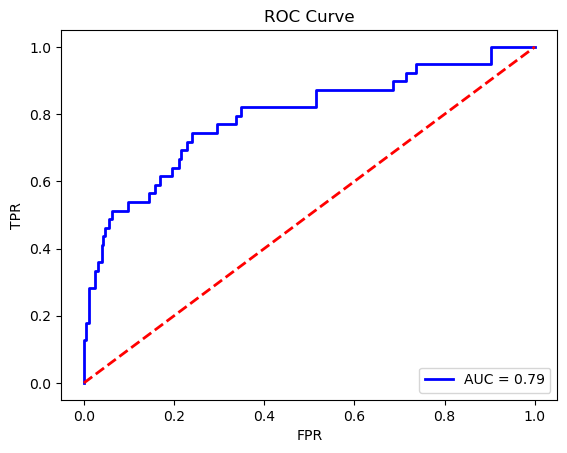

AUC-ROC Score: 0.7941679235796884
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       255
           1       0.59      0.41      0.48        39

    accuracy                           0.88       294
   macro avg       0.75      0.68      0.71       294
weighted avg       0.87      0.88      0.88       294



In [14]:
from sklearn.metrics import classification_report, roc_curve


fpr, tpr, th = roc_curve(y_test, simple_yhat) 
auc = roc_auc_score(y_test, simple_yhat)

lw = 2
plt.plot(fpr, tpr, color='blue', lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC-ROC Score:", auc)

#Classification Report
print("Classification Report:")
print(classification_report(y_test, yhat))

## Neural Network

Neural networks, particularly multi-layer perceptrons (MLPs), are powerful tools for modeling complex patterns in data. Their ability to learn non-linear relationships makes them well-suited for predicting employee attrition, where patterns may be influenced by various interconnected factors such as employee demographics, job satisfaction, and performance metrics. In this approach, we use sklearn's ```MLPClassifier``` to implement a neural network, implementing techniques such as data preprocessing, oversampling with SMOTE to address class imbalance, and model evaluation using metrics like accuracy, classification reports, confusion matrices, and ROC curves. The model is trained and validated on a stratified split dataset, ensuring balanced representation of classes in each split.

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'

We used SMOTE to oversample the minority data ('yes' in attrition). This allows us to better predict the minority class with our model.

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Then we proceed to initialized the construction of the MLP model. We tuned the model to maximize the area under the ROC curve. Since we have an imbalanced dataset, area under the ROC curve is a better indication for our model's performance compared to raw accuracy of validation set, since just looking at the raw accuracy can be misleading.

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 512, 256),
    activation='logistic',
    solver='adam',
    max_iter=3000,
    random_state=42,
    early_stopping=True
)

# Train the model on the resampled training data
mlp.fit(X_train_resampled, y_train_resampled)

The model's predictions are evaluated on the validation set using metrics like accuracy, a classification report, and a confusion matrix to understand its performance.

In [18]:
# Predict probabilities on the validation set
y_val_pred_proba = mlp.predict_proba(X_test)[:, 1]

# Predict classes on the validation set
y_val_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_val_pred)
print("Validation Accuracy:", accuracy)

print("\nClassification Report (Validation Set):")
print(classification_report(y_test, y_val_pred))

print("Confusion Matrix (Validation Set):")
print(confusion_matrix(y_test, y_val_pred))

Validation Accuracy: 0.8299319727891157

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       255
           1       0.40      0.54      0.46        39

    accuracy                           0.83       294
   macro avg       0.66      0.71      0.68       294
weighted avg       0.86      0.83      0.84       294

Confusion Matrix (Validation Set):
[[223  32]
 [ 18  21]]


The ROC AUC score and ROC curve are used to evaluate the model's discriminatory power, showing the trade-off between true positive rate and false positive rate.

ROC AUC Score (Validation Set): 0.7961789844142786


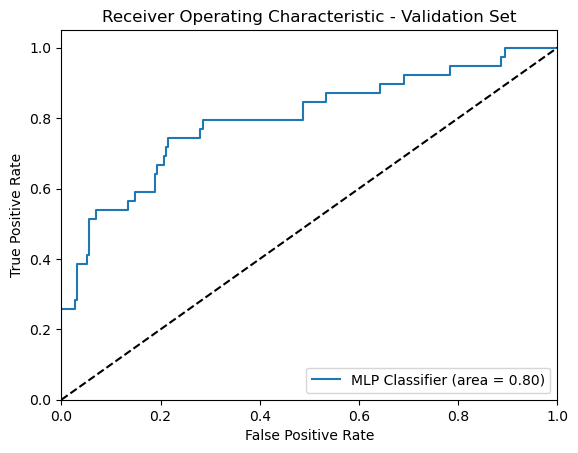

In [19]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_val_pred_proba)
print("ROC AUC Score (Validation Set):", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='MLP Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

The baseline accuracy is also produced for comparison. Because we have a high imbalance of data (~83% 'no'), our baseline accuracy is very high.

However, because of our imbalanced dataset, the ROC AUC is a better indication of how well our model is doing. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds. The area under the ROC curve represents how well the model can distinguish between classes across all possible thresholds:
* A value of 1.0 indicates perfect classification.
* A value of 0.5 indicates random guessing.

Since the ROC AUC score evaluates the model's performance across all possible thresholds, not just a single threshold (like accuracy does). This ensures a more comprehensive view of the model's ability to separate classes. Unlike accuracy, which can be skewed by the majority class, the ROC AUC score remains a solid metric because it evaluates the ranking of predictions (how well the model separates positive and negative classes) rather than absolute predictions.

In [20]:
baseline_accuracy = y_test.value_counts(normalize=True).max()
print("\nBaseline Accuracy (Guessing the majority class):", baseline_accuracy)


Baseline Accuracy (Guessing the majority class): 0.8673469387755102


## Random Forest

Random Forest is a versatile and robust machine learning algorithm known for its ability to handle both classification and regression problems effectively. It operates as an ensemble learning method, combining the predictions of multiple decision trees to enhance overall performance and reduce overfitting. Random Forest is particularly powerful in handling datasets with mixed data types (categorical and numerical) and is less sensitive to feature scaling.

The following libraries are used for the Random Forest model:

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

This a function to Load and preprocess the dataset.

The function reads a CSV file into a pandas DataFrame, encodes the target variable
'Attrition' into binary values (1 for 'Yes', 0 for 'No'), and applies one-hot encoding
to specified categorical columns. It returns the preprocessed DataFrame, ready for
further analysis or machine learning.

In [5]:
# Load and preprocess the data
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)

    # Encode the target variable
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

    # One-hot encode categorical variables
    categorical_columns = [
        'BusinessTravel', 'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'Over18', 'OverTime'
    ]
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    # Drop irrelevant columns (e.g., EmployeeNumber)
    df = df.drop(['EmployeeNumber'], axis=1)

    return df

### Load and preprocess the dataset

Load and preprocess the dataset, then split it into features (X) and target variable (y).

The data is split into training, validation, and test sets using an 80:10:10 ratio:
- First, the dataset is split into a combined train-validation set (90%) and a test set (10%).
- Then, the train-validation set is further split into training (80% of the data) and validation (10% of the data).
- Stratified sampling ensures the target variable's distribution remains consistent across splits.

In [6]:
# Load the dataset
file_path = "EmployeeAttritionAllData.csv"
data = load_and_preprocess(file_path)

# Split the dataset into features and target variable
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Train-validation-test split: 80:10:10
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=2024
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, stratify=y_train_val, random_state=2024
)

### Verify Data
Print the number of rows in the training, validation, and test sets to verify the splits.
Additionally, check if the validation and test sets are distinct by ensuring their indices do not overlap.

In [19]:
print("Training rows:", X_train.shape[0])
print("Validation rows:", X_val.shape[0])
print("Test rows:", X_test.shape[0])
print("Are validation and test sets distinct?:", set(X_val.index).isdisjoint(set(X_test.index)))

Training rows: 1176
Validation rows: 147
Test rows: 147
Are validation and test sets distinct?: True


### Train a Random Forest model using GridSearchCV for hyperparameter tuning. 

- `GridSearchCV` performs a grid search over specified hyperparameters, including the number of estimators, 
  maximum tree depth, feature selection strategy, and minimum samples required for splitting nodes.
- The best model is selected based on accuracy after 3-fold cross-validation.

After training, the best model (`best_rf`) is evaluated on the validation set by making predictions (`y_val_pred`) 
and calculating the class probabilities (`y_val_pred_proba`).

In [20]:
# Train a Random Forest model with GridSearchCV
rf = RandomForestClassifier(random_state=2024)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
}
grid = GridSearchCV(
    rf, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1
)
grid.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate on validation set
y_val_pred = best_rf.predict(X_val)
y_val_pred_proba = best_rf.predict_proba(X_val)[:, 1]

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


### Evaluate the Random Forest model on the validation set:

1. Compute the validation accuracy using `accuracy_score`.
2. Generate a detailed classification report for the validation set, including metrics such as precision, recall, 
   F1-score, and support for each class.

In [21]:
# Compute the validation accuracy
validation_accuracy = accuracy_score(y_val, y_val_pred)
print("\nValidation Accuracy:", validation_accuracy)

# Generate the classification report for the validation dataset
validation_report = classification_report(y_val, y_val_pred, output_dict=True)

# Convert the dictionary to a DataFrame for display
validation_report_df = pd.DataFrame(validation_report).transpose()

# Print the classification report as a table
print("\nClassification Report (Validation):")
display(validation_report_df)


Validation Accuracy: 0.8435374149659864

Classification Report (Validation):


,precision,recall,f1-score,support
0,0.847222,0.991870,0.913858,123.000000
1,0.666667,0.083333,0.148148,24.000000
accuracy,0.843537,0.843537,0.843537,0.843537
macro avg,0.756944,0.537602,0.531003,147.000000
weighted avg,0.817744,0.843537,0.788844,147.000000


### Generate and display the confusion matrix for the validation dataset:

Use `confusion_matrix` to compute the matrix, summarizing the model's performance in terms of:
   - True Negatives (TN)
   - True Positives (TP)
   - False Negatives (FN)
   - False Positives (FP)

In [22]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Create a DataFrame for better display
cm_df = pd.DataFrame(
    cm,
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
# Print the confusion matrix as a table
print("\nConfusion Matrix (Validation):")
display(cm_df)


Confusion Matrix (Validation):


,Predicted 0,Predicted 1
Actual 0,122,1
Actual 1,22,2


### Compute and display the ROC-AUC score for the test set:

In [23]:
roc_auc_validation = roc_auc_score(y_val, y_val_pred_proba)
print("ROC AUC Score (Validation Set):", roc_auc_validation)

ROC AUC Score (Validation Set): 0.8257113821138211


### Generate and display the ROC Curve for the validation set:

1. Compute the ROC-AUC (Receiver Operating Characteristic - Area Under Curve) score using `roc_auc_score`.
   - This measures the model's ability to distinguish between classes.
2. Use `roc_curve` to calculate the False Positive Rate (FPR) and True Positive Rate (TPR) at various thresholds.
3. Plot the ROC curve:
   - The curve shows the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate).
   - Include a dashed diagonal line (`k--`) as a baseline representing random guessing.
   - Display the AUC value in the legend for reference.

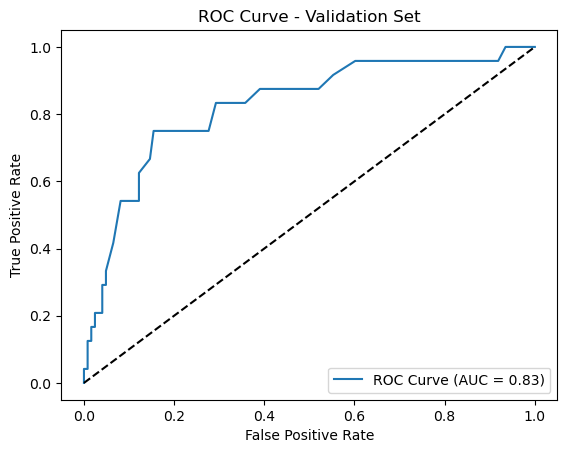

In [24]:
# ROC-AUC and ROC Curve for validation set
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.show()

### Evaluate the model's performance on the test set:

1. Predict the class labels (`y_test_pred`) and class probabilities (`y_test_pred_proba`) for the test dataset.
2. Compute the test accuracy using `accuracy_score` and print the result.
3. Generate the classification report as a dictionary with metrics such as precision, recall, F1-score, and support for each class.

In [25]:
# Test set evaluation
y_test_pred = best_rf.predict(X_test)
y_test_pred_proba = best_rf.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest Accuracy:", test_accuracy)
# print("\nClassification Report (Test):")
# print(classification_report(y_test, y_test_pred))


# Generate the classification report as a dictionary
report = classification_report(y_test, y_test_pred, output_dict=True)

# Convert the dictionary to a DataFrame for display
report_df = pd.DataFrame(report).transpose()

# Print the classification report as a table
print("\nClassification Report (Test):")
display(report_df)


Test Accuracy: 0.8435374149659864

Classification Report (Test):


,precision,recall,f1-score,support
0,0.852113,0.983740,0.913208,123.000000
1,0.600000,0.125000,0.206897,24.000000
accuracy,0.843537,0.843537,0.843537,0.843537
macro avg,0.726056,0.554370,0.560052,147.000000
weighted avg,0.810951,0.843537,0.797891,147.000000


### Compute and display the confusion matrix for the test set:

Use `confusion_matrix` to calculate the matrix, which shows the count of true positives, 
   true negatives, false positives, and false negatives.

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
# Create a DataFrame for better display
cm_df = pd.DataFrame(
    cm,
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
# Print the confusion matrix as a table
print("\nConfusion Matrix (test):")
display(cm_df)


Confusion Matrix (test):


,Predicted 0,Predicted 1
Actual 0,121,2
Actual 1,21,3


### Compute and display the ROC-AUC score for the test set:

In [27]:
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("ROC AUC Score (Test Set):", roc_auc_test)

ROC AUC Score (Test Set): 0.7713414634146342


### Analyze feature importance from the trained Random Forest model:
Extract feature names and their corresponding importance scores using `feature_importances_`.

In [28]:
feature_names = X.columns
feature_importances = best_rf.feature_importances_
# Get indices of the top 3 important features
top_indices = np.argsort(feature_importances)[::-1][:3]

# Print the top 3 features and their importances
print("\nTop 3 Features:\n")
for i in top_indices:
    print(f"Feature: {feature_names[i]:<30} Importance: {feature_importances[i]:.5f}")

# Get indices of the least 3 important features
least_indices = np.argsort(feature_importances)[:3]

# Print the least 3 features and their importances
print("\nLeast 3 Features:\n")
for i in least_indices:
    print(f"Feature: {feature_names[i]:<30} Importance: {feature_importances[i]:.5f}")



Top 3 Features:

Feature: MonthlyIncome                  Importance: 0.06703
Feature: TotalWorkingYears              Importance: 0.05419
Feature: Age                            Importance: 0.05270

Least 3 Features:

Feature: EmployeeCount                  Importance: 0.00000
Feature: StandardHours                  Importance: 0.00000
Feature: JobRole_Research Director      Importance: 0.00103


### Perform cross-validation to evaluate the model's performance:
Use `cross_val_score` to calculate accuracy scores for the model (`best_rf`) across 5 folds of the dataset.
   - The dataset is split into 5 subsets, and the model is trained on 4 subsets while being validated on the remaining subset.
   - This process repeats for all folds to ensure robust evaluation.

In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
cross_val_accuracy = scores.mean()
print("Cross-validation Accuracy:", cross_val_accuracy)


Cross-validation Accuracy: 0.8571428571428571


### Create and display a summary table for model accuracies:

In [30]:
# Create a summary table
accuracy_summary = {
    "Accuracy Type": ["Validation", "Test", "Cross-Validation"],
    "Accuracy": [validation_accuracy, test_accuracy, cross_val_accuracy]
}

# Convert to DataFrame for better display
accuracy_summary_df = pd.DataFrame(accuracy_summary)

# Display the table
print("\nAccuracy Summary:")
display(accuracy_summary_df.style.hide(axis="index"))


Accuracy Summary:


Accuracy Type,Accuracy
Validation,0.843537
Test,0.843537
Cross-Validation,0.857143
